# LE-SDE Experiments

In [1]:
from __future__ import print_function, absolute_import, division
%load_ext autoreload
%autoreload 2

import sys, os, json, requests, time, datetime, logging, multiprocessing
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
TORCH_DEV = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.is_available()

True

In [4]:
import src.utils as utils
import src.datasets as datasets
import src.plotter as plotter

LOCAL_DATA_PATH =  Path('./data')
EXP_DATA_PATH = Path('./exp_data')

## Load Datasets

#### GeoMNIST

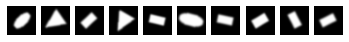

In [5]:
# show examples of GeoMNIST (optional)

plotter.viz_imglist(datasets.gen_geomnist_data(800, 200, (32, 32))[2][0][np.random.choice(2400, 10)])

#### CIFAR-10

In [6]:
# change LOCAL_DATA_PATH / 'vision' to the path where CIFAR10 from torchvision is stored

CIFAR10 = datasets.get_cifar10(datasets.load_cifar10( LOCAL_DATA_PATH/'vision' ))

Files already downloaded and verified
Files already downloaded and verified


## Running Experiments

In [7]:
from src.models import SimpleConv, SimpleConv3d

### GeoMNIST (w/ different numbers of samples per class)

In [8]:
smp_cfg = [(40,10), (80,20), (240, 60), (480, 120), (800, 200), (2400, 600), (4800, 1200)]
n_iters = 10000
n_trials = 100
lr = 0.005
data_shape = (32, 32)
dataset_name = 'geom'

In [9]:
for idx, (n_tr, n_val) in enumerate(smp_cfg):
    n_smp_per_cls, n_classes, geomnist_data = datasets.gen_geomnist_data(n_tr, n_val, data_shape)
    save_file = EXP_DATA_PATH / f'{dataset_name}_K{n_classes}_m{int(n_smp_per_cls)}_it{n_iters//1000}k_l{lr}.csv'
    utils.console_log(f"[{idx:3d}] {n_smp_per_cls} smps, save to {save_file}")
    
    utils.train(geomnist_data, n_trials, n_iters, save_file, lr,
                device=TORCH_DEV, n_channels=1, verbose=False, 
                model_kws={'lr': lr, 'model_func':SimpleConv, 'n_classes':n_classes, 'data_shape': data_shape})
    


### GeoMNIST (w/ different label corruption ratio $p$)

In [10]:
dataset_name = 'geom'
n_tr, n_val = 500, 500
n_iters = 10000
n_trials = 100
lr = 0.005
data_shape = (32, 32)
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 2/3, 0.7, 0.8]

In [11]:
for idx, p in enumerate(ps):
    n_smp_per_cls, n_classes, geomnist_data = datasets.gen_geomnist_data(n_tr, n_val, data_shape)
    n_pert = int(p * n_tr)
    c_inv = [[1,2], [0,2], [0,1]]
    for c in range(n_classes):
        pert_idx = np.random.choice(np.arange(c*n_tr, (c+1)*n_tr), n_pert, replace=False)
        geomnist_data[1][pert_idx[:n_pert//2]] = c_inv[c][0]
        geomnist_data[1][pert_idx[n_pert//2:]] = c_inv[c][1]

    save_file = EXP_DATA_PATH / f'{dataset_name}_K{n_classes}_p{p}.csv'
    utils.console_log(f"[{idx:3d}] {p} random labels, save to {save_file}")
    
    utils.train(geomnist_data, n_trials, n_iters, save_file, lr, device=TORCH_DEV,
                n_channels=1, verbose=False, 
                model_kws={'lr': lr, 'model_func':SimpleConv, 'n_classes':n_classes, 'data_shape': data_shape})
    


### CIFAR-10 (w/ different number of classe)

In [12]:
dataset_name = 'CIFAR10'
smp_cfg = [2, 3, 4, 5]

n_iters = 30000
n_trials = 100
lr = 0.001

n_tr=2000
n_val=500
n_tot_tr = 5000
n_tot_va = 1000
data_shape = (32, 32)
n_smp_per_cls = n_tr + n_val

In [13]:
for idx, n_cls in enumerate(smp_cfg):
    CIFAR_data = datasets.get_random_smps(*CIFAR10, n_tr=n_tr, n_va=n_val,
                                          n_tot_tr=n_tot_tr, n_tot_va=n_tot_va, n_c=n_cls)
    save_file = EXP_DATA_PATH / f'{dataset_name}_K{n_cls}_m{int(n_smp_per_cls)}_it{n_iters//1000}k_l{lr}.csv'
    utils.console_log(f"[{idx:3d}] {n_smp_per_cls} smps, save to {save_file}")
    
    utils.train(CIFAR_data, n_trials, n_iters, save_file, lr, device=TORCH_DEV,
                n_channels=3, verbose=False, 
                model_kws={'lr': lr, 'model_func':SimpleConv3d, 'n_classes':n_cls, 'data_shape': data_shape})

    
